# Classifying Loan Data 

### Summary
**Big Picture Summary:** The purpose of this notebook is to develop a machine learning model for the conservative investor in Lending Club. The data used in this notebook was cleaned in the [Data_Wrangling.ipynb](https://github.com/paulb17/Springboard/blob/master/Capstone%20Project%201/Data_Wrangling%20.ipynb) notebook. Following this, the data was explored in the notebook [Data_Exploration.ipynb](https://github.com/paulb17/Springboard/blob/master/Capstone%20Project%201/Data_Exploration.ipynb). 

In this notebook 
...


## Importing the data

In [392]:
# importing relevant packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.cm as cm
import itertools
import xgboost as xgb

# importing useful functions
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import cross_val_predict, KFold, train_test_split 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score, roc_curve
from sklearn.ensemble import VotingClassifier




# creating plots using seaborn setting 
sns.set()

# using jupyter magic to display plots in line
%matplotlib inline

# importing the dataset
loan_data = pd.read_csv('Wrangled_Loan_data.csv', low_memory=False)

## Machine Learning Models
Prior to creating machine learning models, it is important to determine a measure of accuracy that will be used to compaere it with other models. Below we outline the metric chosen for comparing the data.

### Method of Comparison

The sensitivity and specificity will be used as metrics to determine how worthwhile the final model is to the conservative investor. For this problem, sensitivy is interpreted as the number of loans that the model correctly predicts will be fully paid as a percentage of the total number of loans that is fully paid. Addtionally, specificity is the number of loans that the model incorrectly predicts is fully paid as a percentage of the total number of loans that are charged off.

Since this problem is viewed from the standpoint of a conservative investor, false positives should be treated differently than false negatives. Conservative investors would want to minimize risk, and avoid false positives as much as possible: they would not mind missing out on opportunities (false negatives) as much as they would mind funding a risky loan (false positives). Consequently, the specificity metric will be more important than the sensitivity metric.

In order to identify the best model to use for the conservative investor each machine learning algorithm will be compared using the AUROC (Area Under the Receiver Operating Characteristics)

### Creating the baseline model
A logistic regression model using the default sklearn parameters will serve as a baseline model. 

In [407]:
# creating list of features
loan_features = loan_data.drop(['loan_status'], axis =1)
features = list(loan_features.columns)

# train test set split
X_train, X_test, y_train, y_test = train_test_split(loan_data[features], loan_data["loan_status"], 
                                                    train_size = 0.75, test_size = 0.25, 
                                                    random_state = 42)

# instantiating baseline logistic regression model
base_lr_model = LogisticRegression(solver = 'liblinear')

# setting the number of folds
kf = KFold(10, random_state = 1)
    
# fitting the model and computing predictions
base_lr_model.fit(X_train, y_train)
base_prediction_train = cross_val_predict(base_lr_model, X_train, y_train, cv=kf, method='predict_proba')

# calcluating the AUROC for the training set
base_train_roc = roc_auc_score(y_train, base_prediction_train[:,1])
print('For the training set the AUROC is:' + str(base_train_roc)+ '\n' )

# predicting results on test set
base_prediction_test = base_lr_model.predict_proba(X_test)

# calculating the AUROC for the test set
base_test_roc = roc_auc_score(y_test, base_prediction_test[:,1])
print('For the hold-out set the AUROC is:' + str(base_test_roc))

For the training set the AUROC is:0.67817826579

For the hold-out set the AUROC is:0.67149779989


The AUROC score of the baseline model is about 0.672. Let's take a look at the confusion matrix to get more insight into the model's incorrect predictions. 

In [551]:
sns.set(font_scale=1.5)

Confusion matrix, without normalization
[[   3 1392]
 [   7 8532]]


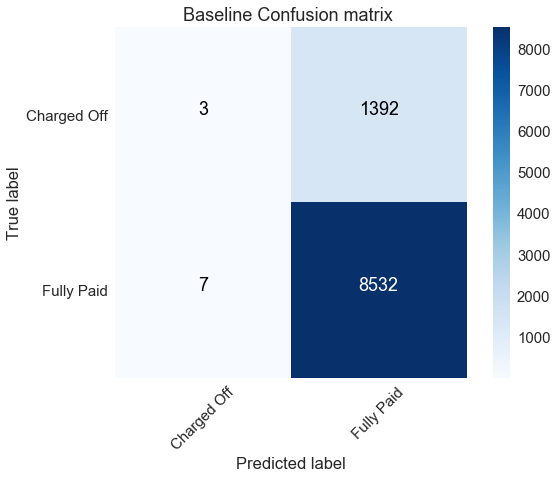

In [552]:
# function to display confusion matrix 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    '''Function to display confusion matrix from sickit learn
    documentation'''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.grid(False)


# Compute confusion matrix
cnf_matrix= confusion_matrix(y_test, base_lr_model.predict(X_test))
class_names = ['Charged Off', "Fully Paid"]
np.set_printoptions(precision=2)

# Plot hold out set confusion matrix
plt.figure(figsize = (9,7))
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Baseline Confusion matrix ')

We see that most of the borrowers in the baseline model are predicted to fully pay off their loans. This is as a result of the class imbalance in the dataset. There are 6 times more borrowers with loans that were paid off on time (1), than there are with loans that were charged off (0). To account for this, a grid search will be carried out using different weights. 

Below, we start by creating a function to implement this grid search. 

### Creating a grid search function to fit and test models
The function created below takes in a classification model and tunes hyper parameters. It outputs the confusion matrix and the AUROC for the optimal hyperparameters in the grid.

In [422]:
def classification_model(model, param_grid, score = 'roc_auc'):
    
    # setting the number of folds
    kf = KFold(10, random_state=1)
    
    # Instantiate the GridSearchCV object: cv
    model_cv = GridSearchCV(model, param_grid, cv = kf, scoring = score, 
                            return_train_score = True, n_jobs = -3)
    
    # Fitting the training set 
    model_cv.fit(X_train.astype(float), y_train.astype(float))
        
    # Predict the labels of the test set: y_pred        
    y_pred = model_cv.predict_proba(X_test.astype(float))[:,1]
    
    # Printing best parametrs
    print("Tuned Model Parameters: {}".format(model_cv.best_params_))
    
     # Printing the corresponding AUROC "
    test_roc = roc_auc_score(y_test, y_pred)
    print('The hold-out set AUROC = ' + str(test_roc))
    
    # Compute confusion matrix
    cnf_matrix= confusion_matrix(y_test, model_cv.predict(X_test.astype(float)))
    class_names = ['Charged Off', "Fully Paid"]
    np.set_printoptions(precision=2)

    # Plot hold out set confusion matrix
    plt.figure(figsize = (9,7))
    plot_confusion_matrix(cnf_matrix, classes=class_names, title='Hold-out set Confusion matrix ')
    
    return pd.DataFrame(model_cv.cv_results_)


### Logistic Regression with varying class weights and regularization parameter
Below we tune the class weights to account for the class imbalance in the dataset. Furthermore, we also attempt to tune the regularization parameter to get a better understanding of its effect on the model. 

Tuned Model Parameters: {'C': 1, 'class_weight': {0: 7, 1: 1}}
The hold-out set AUROC = 0.696480369848
Confusion matrix, without normalization
[[1000  395]
 [3620 4919]]
CPU times: user 3.89 s, sys: 1.08 s, total: 4.97 s
Wall time: 4min 47s


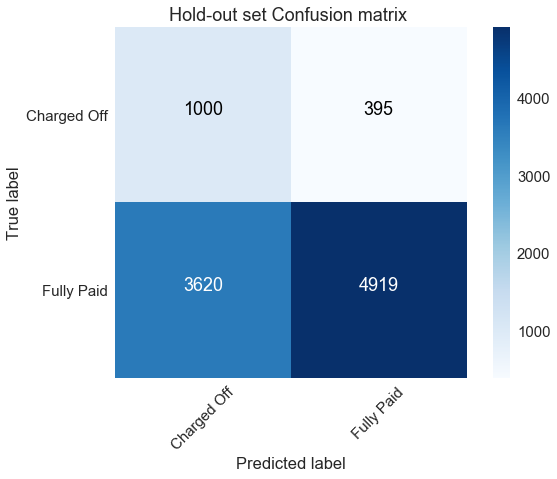

In [553]:
# c _space
c_space =[0.01, 0.1, 0.3, 1, 3, 10, 30, 100, 300]

# parameters for grid search 
param_grid = {'C': c_space, 'class_weight':[{0:6, 1:1}, 'balanced', {0:7,1:1}, {0:8,1:1}]}

# calculating results
%time results = classification_model(base_lr_model, param_grid) 

Grid search results indicate that the best AUROC value comes from a model in which the penalty for misclassifying charged off loans is 7 times the penalty for misclassifying fully paid loans. The new AUROC value of 0.696 is a significant improvement from the initial 0.672.

Below we take a look at the cross validation training and test scores to ensure the model is not overfitting on the training data. In addition, we hope to get some insight into which hyper parameters influenced the model performance.

In [411]:
# columns of importance
result_columns = ['rank_test_score', 'params', 'mean_test_score', 'mean_train_score']
results[result_columns].sort_values('rank_test_score').head()

,rank_test_score,params,mean_test_score,mean_train_score
10,1,"{'C': 0.3, 'class_weight': {0: 7, 1: 1}}",0.702256,0.707904
2,2,"{'C': 0.01, 'class_weight': {0: 7, 1: 1}}",0.702075,0.707907
28,3,"{'C': 100, 'class_weight': {0: 6, 1: 1}}",0.702071,0.707181
34,4,"{'C': 300, 'class_weight': {0: 7, 1: 1}}",0.702047,0.708385
6,5,"{'C': 0.1, 'class_weight': {0: 7, 1: 1}}",0.701998,0.708573
30,6,"{'C': 100, 'class_weight': {0: 7, 1: 1}}",0.701953,0.707268
18,7,"{'C': 3, 'class_weight': {0: 7, 1: 1}}",0.701892,0.707649
22,8,"{'C': 10, 'class_weight': {0: 7, 1: 1}}",0.701546,0.707911
26,9,"{'C': 30, 'class_weight': {0: 7, 1: 1}}",0.701546,0.707715
14,10,"{'C': 1, 'class_weight': {0: 7, 1: 1}}",0.701530,0.707973


**NOTE:** The mean training and test scores shown in the above table are from applying cross validation to the training set. 

By reviewing the top 10 model scores, we note that while varying the regularization parameter "C" has an affect on AUROC values, the differences it makes in AUROC scores is small.  The class weight paramater has a more significant impact on the model choice.

Let's look into whether another machine learning algorithm could further improve the AUROC of the test set.

### Random Forest Classification
There are a lot of parameters that may be worth tuning. To investigate this, we start by creating a function to randomly search through a selected grid of random forest parameters. Following this, the parameters that appear to be the most important will then be tuned using grid search. 

**Creating a function for randomized searching**

In [414]:
def random_search(model, random_grid, score = 'roc_auc', iterations = 30):
    
    # setting the number of folds
    kf = KFold(10, random_state=1)
    
    # Instantiate the GridSearchCV object: cv
    model_cv = RandomizedSearchCV(model, random_grid, n_iter = iterations, cv = kf, 
                                  scoring = score, return_train_score = True, n_jobs=-3)
    
    # Fitting the training set 
    model_cv.fit(X_train, y_train)
        
    # Predict the labels of the test set: y_pred        
    y_pred = model_cv.predict_proba(X_test)[:,1]

    # Printing best parametrs
    print("Tuned Model Parameters: {}".format(model_cv.best_params_))
    
     # Printing the corresponding AUROC 
    test_roc = roc_auc_score(y_test, y_pred)
    print('The test set AUROC = ' + str(test_roc))
    
    # Compute confusion matrix
    cnf_matrix= confusion_matrix(y_test, model_cv.predict(X_test.astype(float)))
    class_names = ['Charged Off', "Fully Paid"]
    np.set_printoptions(precision=2)

    # Plot hold out set confusion matrix
    plt.figure(figsize = (9,7))
    plot_confusion_matrix(cnf_matrix, classes=class_names, title='Hold-out set Confusion matrix ')
    
    return pd.DataFrame(model_cv.cv_results_)

**Implementing randomized search on the random forest model**

It should be noted that multiple randomized searches were implemented to narrow down a set of parameters that do not result in an overfitting of the training data. The following parameters were evaluated:
* class weight - ranging from {0:5, 1:1} to {0:8, 1:1} 
* max features - 'sqrt' and 'log2'
* minimum sample split - ranging from 1 to 9
* minimum sample leaf - ranging from 1 to 20
* number of estimators - ranging from 10 to 250
* bootstrap - TRUE or FALSE
* criterion - gini or entropy

The code for the final randomized search performed is shown below. 

Tuned Model Parameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 60, 'max_features': 'sqrt', 'max_depth': 11, 'criterion': 'gini', 'class_weight': {0: 6, 1: 1}, 'bootstrap': True}
The test set AUROC = 0.691950363943
Confusion matrix, without normalization
[[ 847  548]
 [2903 5636]]
CPU times: user 8.06 s, sys: 724 ms, total: 8.78 s
Wall time: 11min 35s


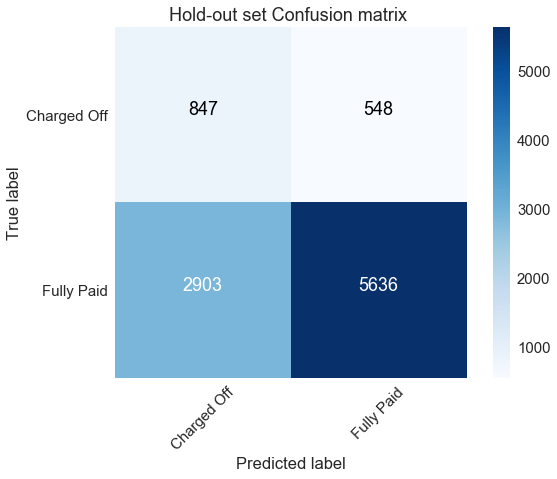

In [558]:
# creating model object and evaluating result 
rf_model = RandomForestClassifier()

# parameters for randomized search 
random_grid = {'class_weight':[{0:5.5,1:1},{0:6,1:1},'balanced'],
               'max_features': ['sqrt'],
               'max_depth': [10,11],
               'min_samples_split': [5,6,7,10],
               'min_samples_leaf': [60, 70, 90],
               'n_estimators': [200],
               'bootstrap' : [True], 
               'criterion':['gini']}

# calculating results
%time random_rf_results = random_search(rf_model, random_grid, iterations = 20)  

In [417]:
# displaying the top 10 models by mean AUROC score
pd.options.display.max_colwidth = 300
random_rf_results[result_columns].sort_values('rank_test_score').head(10)

,rank_test_score,params,mean_test_score,mean_train_score
19,1,"{'n_estimators': 200, 'min_samples_split': 7, 'min_samples_leaf': 60, 'max_features': 'sqrt', 'max_depth': 11, 'criterion': 'gini', 'class_weight': {0: 6, 1: 1}, 'bootstrap': True}",0.694275,0.751514
9,2,"{'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 70, 'max_features': 'sqrt', 'max_depth': 11, 'criterion': 'gini', 'class_weight': {0: 5.5, 1: 1}, 'bootstrap': True}",0.694188,0.745766
0,3,"{'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 60, 'max_features': 'sqrt', 'max_depth': 11, 'criterion': 'gini', 'class_weight': {0: 5.5, 1: 1}, 'bootstrap': True}",0.694060,0.751460
7,4,"{'n_estimators': 200, 'min_samples_split': 7, 'min_samples_leaf': 60, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'gini', 'class_weight': {0: 5.5, 1: 1}, 'bootstrap': True}",0.693921,0.744948
14,5,"{'n_estimators': 200, 'min_samples_split': 6, 'min_samples_leaf': 60, 'max_features': 'sqrt', 'max_depth': 11, 'criterion': 'gini', 'class_weight': 'balanced', 'bootstrap': True}",0.693835,0.751479
11,6,"{'n_estimators': 200, 'min_samples_split': 7, 'min_samples_leaf': 70, 'max_features': 'sqrt', 'max_depth': 11, 'criterion': 'gini', 'class_weight': {0: 6, 1: 1}, 'bootstrap': True}",0.693794,0.745699
4,7,"{'n_estimators': 200, 'min_samples_split': 7, 'min_samples_leaf': 60, 'max_features': 'sqrt', 'max_depth': 11, 'criterion': 'gini', 'class_weight': 'balanced', 'bootstrap': True}",0.693631,0.751481
6,8,"{'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 60, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'gini', 'class_weight': {0: 6, 1: 1}, 'bootstrap': True}",0.693516,0.744863
12,9,"{'n_estimators': 200, 'min_samples_split': 7, 'min_samples_leaf': 70, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'gini', 'class_weight': {0: 6, 1: 1}, 'bootstrap': True}",0.693391,0.740491
15,10,"{'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 70, 'max_features': 'sqrt', 'max_depth': 11, 'criterion': 'gini', 'class_weight': 'balanced', 'bootstrap': True}",0.693299,0.746000


We note that most of the models above are slightly overfit on the training set. Further reductions in the difference between cross validation training and test scores set only reduces the AUROC for the hold out set. It appears the best AUROC value that can be obtained from the cross validation test set without significant overfitting is approximately 0.694. 

The corresponding hold out set has an AUROC of 0.692. This is worse than the prior 0.697 obtained using logistic regression. A grid search is performed to determine whether further improvements can be made to the model. 

**Grid search with cross validation on Random Forest**

Tuned Model Parameters: {'bootstrap': True, 'class_weight': {0: 6, 1: 1}, 'max_depth': 11, 'max_features': 'sqrt', 'min_samples_leaf': 60, 'min_samples_split': 3, 'n_estimators': 200}
The hold-out set AUROC = 0.692364235611
Confusion matrix, without normalization
[[ 847  548]
 [2885 5654]]
CPU times: user 10.2 s, sys: 1.27 s, total: 11.5 s
Wall time: 20min 19s


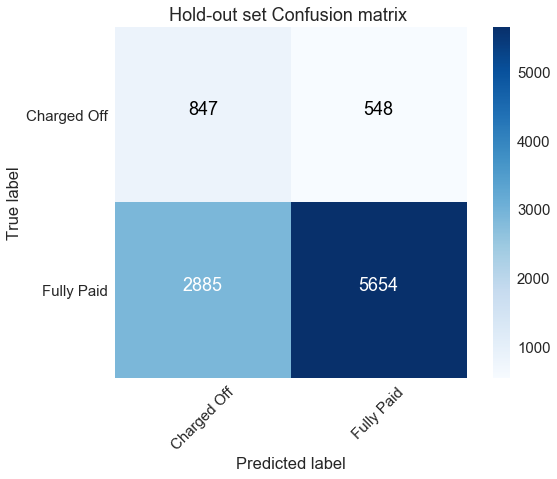

In [556]:
# parameters for grid search
rf_param_grid = {'class_weight':[{0:6, 1:1},'balanced', {0:7,1:1}],
               'max_features': ['sqrt'],
               'max_depth': [11],
               'min_samples_split': [3, 6, 7, 10],
               'min_samples_leaf': [60, 70, 80],
               'n_estimators': [200],
               'bootstrap' : [True]}

# calculating results
%time grid_rf_results = classification_model(rf_model, rf_param_grid) 

In [557]:
# displaying top 10 models by mean AUROC score
grid_rf_results[result_columns].sort_values('rank_test_score').head()

,rank_test_score,params,mean_test_score,mean_train_score
0,1,"{'bootstrap': True, 'class_weight': {0: 6, 1: 1}, 'max_depth': 11, 'max_features': 'sqrt', 'min_samples_leaf': 60, 'min_samples_split': 3, 'n_estimators': 200}",0.694080,0.751759
15,2,"{'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 11, 'max_features': 'sqrt', 'min_samples_leaf': 60, 'min_samples_split': 10, 'n_estimators': 200}",0.693930,0.751436
1,3,"{'bootstrap': True, 'class_weight': {0: 6, 1: 1}, 'max_depth': 11, 'max_features': 'sqrt', 'min_samples_leaf': 60, 'min_samples_split': 6, 'n_estimators': 200}",0.693908,0.751286
14,4,"{'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 11, 'max_features': 'sqrt', 'min_samples_leaf': 60, 'min_samples_split': 7, 'n_estimators': 200}",0.693891,0.752282
12,5,"{'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 11, 'max_features': 'sqrt', 'min_samples_leaf': 60, 'min_samples_split': 3, 'n_estimators': 200}",0.693862,0.751508


The optimal hyperparameters from the grid search are relatively less overfit on the training set than the optimal hyperparameters from the random search. We obtained a value of 0.6924 for the AUROC of the hold out set which is higher than the AUROC of 0.6919 obtained via the random search. We conclude that the grid search didn't significantly improve the AUROC values of the hold-out set. Next, we try using kernel SVM to make further improvements.

### Kernel SVM
The compute and storage requirements of support vector classifiers increase rapidly with the number of the training vectors. Consequently, only one hyper parameter will be tuned at a time. It should be noted that this is not an exhaustive approach and provides a means by which this work could be improved.

#### Grid Search for class weight
We start by tuning the class weight parameter to determine how penalizing prediction errors affect the model performance. 

Tuned Model Parameters: {'svc__C': 1.0, 'svc__class_weight': 'balanced', 'svc__gamma': 'scale'}
The hold-out set AUROC = 0.676936224726
Confusion matrix, without normalization
[[ 810  585]
 [2765 5774]]
CPU times: user 15min 45s, sys: 3.1 s, total: 15min 48s
Wall time: 4h 3min


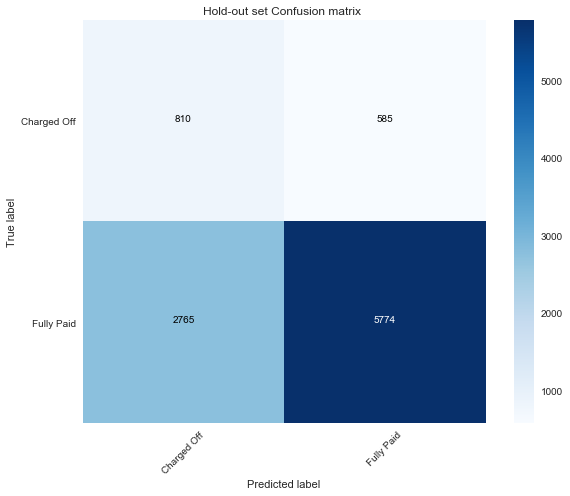

In [423]:
# creating parameters to search through 
C_range = [1.0]
gamma_range = ['scale']

# parameters for grid search
SVC_param_grid = {'svc__class_weight':[{0:6, 1:1},'balanced', {0:7,1:1}], 
                  'svc__gamma' : gamma_range, 
                  'svc__C': C_range }

# Create scaler: scaler
scaler = StandardScaler()

# instantiating classifier
SVC_model = SVC(probability = True)

# creating pipeline
SVC_pipeline = make_pipeline(scaler, SVC_model)

# calculating results
%time grid_SVC_results = classification_model(SVC_pipeline, SVC_param_grid) 


In [424]:
grid_SVC_results[result_columns].sort_values('rank_test_score')


,rank_test_score,params,mean_test_score,mean_train_score
1,1,"{'svc__C': 1.0, 'svc__class_weight': 'balanced', 'svc__gamma': 'scale'}",0.679587,0.854889
0,2,"{'svc__C': 1.0, 'svc__class_weight': {0: 6, 1: 1}, 'svc__gamma': 'scale'}",0.670001,0.886515
2,3,"{'svc__C': 1.0, 'svc__class_weight': {0: 7, 1: 1}, 'svc__gamma': 'scale'}",0.666350,0.892009


We see in the above table that the balanced class weight yielded the best AUROC training set results. The hold out-set  AUROC score is 0.678. Let's try to improve this by tuning other parameters.

#### Grid search for the penalty parameter 
Using the optimized class weights,  the penalty parameter is tuned. 

Tuned Model Parameters: {'svc__C': 0.1, 'svc__class_weight': 'balanced', 'svc__gamma': 'scale'}
The hold-out set AUROC = 0.688352534712
Confusion matrix, without normalization
[[ 934  461]
 [3288 5251]]
CPU times: user 16min 8s, sys: 11.2 s, total: 16min 20s
Wall time: 4h 9min 36s


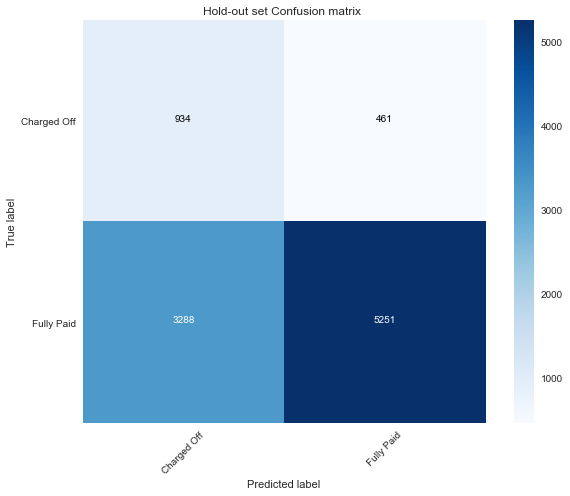

In [429]:
# creating paramerers to search through 
C_range = [0.05, 0.1, 0.5]
gamma_range = ['scale']

# parameters for grid search
SVC_param_grid = {'svc__class_weight':['balanced'], 
                  'svc__gamma' : gamma_range, 
                  'svc__C': C_range }

# creating pipeline
SVC_pipeline = make_pipeline(scaler, SVC_model)

# calculating results
%time grid_SVC_C_results = classification_model(SVC_pipeline, SVC_param_grid) 

In [430]:
grid_SVC_C_results[result_columns].sort_values('rank_test_score')

,rank_test_score,params,mean_test_score,mean_train_score
1,1,"{'svc__C': 0.1, 'svc__class_weight': 'balanced', 'svc__gamma': 'scale'}",0.696072,0.742566
0,2,"{'svc__C': 0.05, 'svc__class_weight': 'balanced', 'svc__gamma': 'scale'}",0.694290,0.723714
2,3,"{'svc__C': 0.5, 'svc__class_weight': 'balanced', 'svc__gamma': 'scale'}",0.690085,0.814828


The above table shows that a penalty parameter of 0.1 yielded the best AUROC training set results. The hold out-set AUROC score is 0.688. Next, we attempt to improve this by tuning the kernel coefficient.

#### Grid search for the kernel coefficient
Using the optimal class weight and penalty parameter found in the above grid searches, the kernel co-efficient is tuned.

Tuned Model Parameters: {'svc__C': 0.1, 'svc__class_weight': 'balanced', 'svc__gamma': 0.01}
The hold-out set AUROC = 0.690371859077
Confusion matrix, without normalization
[[ 927  468]
 [3243 5296]]
CPU times: user 14min 39s, sys: 3.63 s, total: 14min 42s
Wall time: 3h 54min 1s


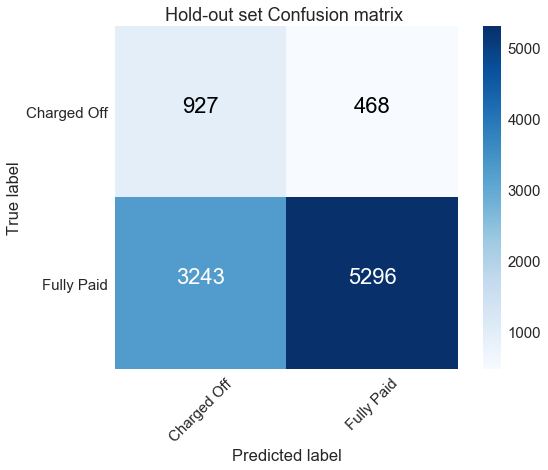

In [574]:
# creating parameters to search through 
C_range = [0.1]
gamma_range = [0.0005, 0.01, 0.05]

# parameters for grid search
SVC_param_grid = {'svc__class_weight':['balanced'], 
                  'svc__gamma' : gamma_range, 
                  'svc__C': C_range }

# creating pipeline
SVC_pipeline = make_pipeline(scaler, SVC_model)

# calculating results
%time grid_SVC_gamma_results = classification_model(SVC_pipeline, SVC_param_grid) 

In [441]:
grid_SVC_gamma_results[result_columns].sort_values('rank_test_score')

,rank_test_score,params,mean_test_score,mean_train_score
1,1,"{'svc__C': 0.1, 'svc__class_weight': 'balanced', 'svc__gamma': 0.01}",0.698285,0.735408
0,2,"{'svc__C': 0.1, 'svc__class_weight': 'balanced', 'svc__gamma': 0.0005}",0.694556,0.699745
2,3,"{'svc__C': 0.1, 'svc__class_weight': 'balanced', 'svc__gamma': 0.05}",0.668163,0.815022


We note that the optimal kernel coefficient from the grid search is 0.1. The corresponding AUROC of the hold-out set  is 0.69. Overall, the support vector classifier appears to perform worse than both the random forest model and the logistic regression model. It is possible that this could be because of the kernel of choice. Consequently, another attempt will be made to improve the support vector classifier by comparing the rbf and poly kernels.

#### Comparing rbf and poly kernels
To save time, the results we obtained using the rbf kernels are compared to the suggested paramaters from the paper [Data-driven advice for applying machine learning to bioinformatics problems](https://arxiv.org/pdf/1708.05070.pdf). The parameters from the paper are listed below:
* C = 0.01
* gamma = 0.1
* kernel = poly
* degree = 3
* coef0 = 10

The balanced class weight parameter will be added to the model to ensure a fair comparison.

Tuned Model Parameters: {'svc__C': 0.01, 'svc__class_weight': 'balanced', 'svc__degree': 3, 'svc__gamma': 0.1, 'svc__kernel': 'poly'}
The hold-out set AUROC = 0.618028434579
Confusion matrix, without normalization
[[ 571  824]
 [2089 6450]]
CPU times: user 24min 33s, sys: 4.04 s, total: 24min 37s
Wall time: 2h 21min 13s


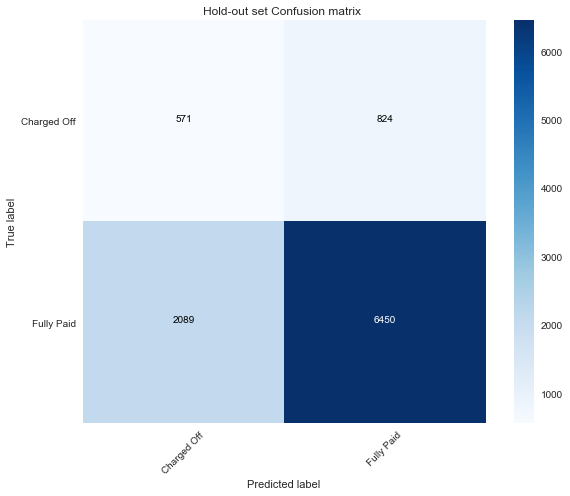

In [442]:
# creating parameters to search through 
C_range = [0.01]
gamma_range = [0.1]

# parameters for grid search
SVC_param_grid = {'svc__class_weight':['balanced'], 
                  'svc__gamma' : gamma_range, 
                  'svc__C': C_range, 
                  'svc__kernel': ['poly'], 
                  'svc__degree': [3]}

# creating pipeline
SVC_pipeline = make_pipeline(scaler, SVC_model)

# calculating results
%time grid_SVC_poly_results = classification_model(SVC_pipeline, SVC_param_grid) 

The poly kernel yielded an AUROC of 0.618. The grid search performed using the rbf kernel appears to yield the better SVC model performance. 

### Preprocessing with PCA 
It is possible reducing the dimensionality of the dataset coule improve model performance. In this section, we look at the effect of preprocessing using PCA prior to creating a logistic regression model. The logistic regression modle was chosen as it performs the best among the three models tested. 

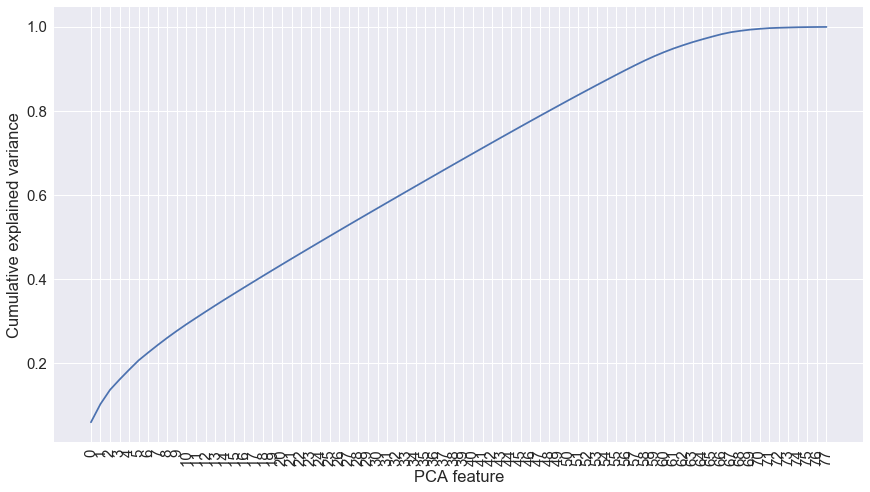

In [569]:
# Create scaler: scaler
scaler = StandardScaler()

# Create a PCA instance: pca
pca = PCA()

# Create pipeline: pipeline
pipeline = make_pipeline(scaler, pca)
 
# Fit the pipeline to 'samples'
pipeline.fit(X_train.astype(float), y_train.astype(float))

# Plot the explained variances
features = range(pca.n_components_)
plt.figure( figsize = (14.5,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('PCA feature')
plt.ylabel('Cumulative explained variance')
plt.xticks(features, rotation = 90)
plt.show()

The plot above shows the cumulative contribution of each principal component to the explained variance. We see that at about 70 princicpal components should be sufficient to fully explain the data. 

Different values of principal components were tested to determine their effect on the hold out set AUROC. A summary of results obtained is shown below:

|Number of Principal components| Hold out set AUROC|
|--------------------|-------------------|
|10| 0.670|
|20| 0.678|
|30|0.680|
|40|0.678|
|50|0.681|
|60|0.687|
|70|0.695|
|78|0.696|

Increasing the number of principal components used in the logistic regression model increased the AUROC. The code used to generate these results is shown below.

Tuned Model Parameters: {'logisticregression__C': 10, 'logisticregression__class_weight': 'balanced'}
The hold-out set AUROC = 0.695030223965
Confusion matrix, without normalization
[[ 879  516]
 [2919 5620]]
CPU times: user 2.51 s, sys: 453 ms, total: 2.96 s
Wall time: 2min 19s


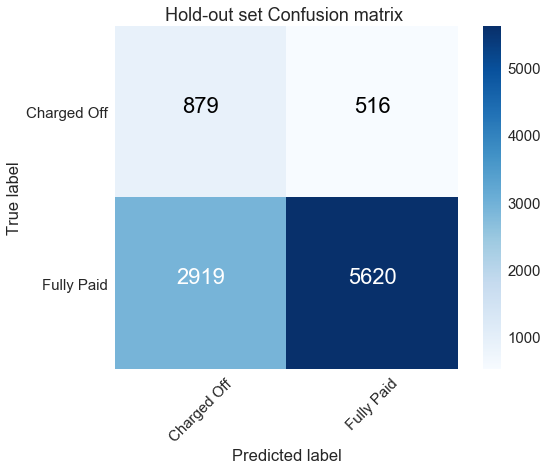

In [573]:
# c _space
c_space =[0.1, 1, 10, 100]

# parameters for grid search 
param_grid = {'logisticregression__C': c_space, 
              'logisticregression__class_weight':[{0:6, 1:1}, 'balanced', {0:7,1:1}, {0:8,1:1}]}

# making pipeline
Logreg_pipeline = make_pipeline(scaler, PCA(n_components = 70), base_lr_model)

# printing results
%time grid_LR_results = classification_model(Logreg_pipeline, param_grid)

In [571]:
# displaying cross validation training set results
grid_LR_results[result_columns].sort_values('rank_test_score').head()


,rank_test_score,params,mean_test_score,mean_train_score
9,1,"{'logisticregression__C': 10, 'logisticregression__class_weight': 'balanced'}",0.701496,0.708965
8,2,"{'logisticregression__C': 10, 'logisticregression__class_weight': {0: 6, 1: 1}}",0.701489,0.708967
5,3,"{'logisticregression__C': 1, 'logisticregression__class_weight': 'balanced'}",0.701488,0.708953
4,4,"{'logisticregression__C': 1, 'logisticregression__class_weight': {0: 6, 1: 1}}",0.701488,0.708955
0,5,"{'logisticregression__C': 0.1, 'logisticregression__class_weight': {0: 6, 1: 1}}",0.701474,0.708940


### Clustering of Dataset
Making further improvements to the model appears to be difficult. Let's see if we can segment borrowers into different groups to get more insight into the Lending Club borrowers. 

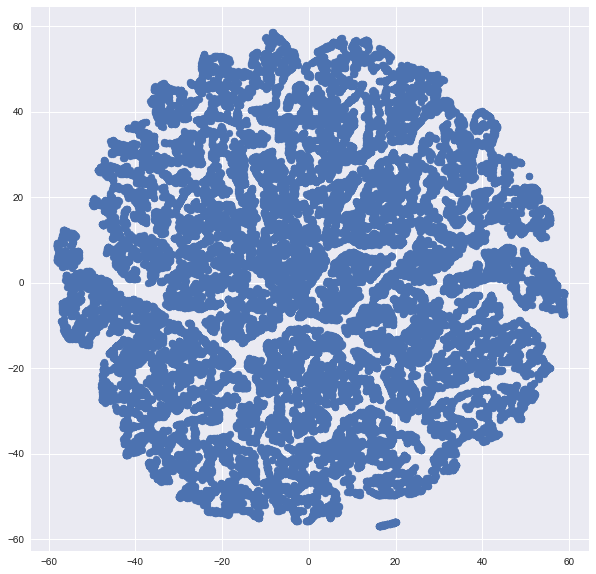

In [284]:
# instantiating the TSNE model
tsne_model = TSNE(learning_rate=100, perplexity = 28)

# creating the features for clustering 
tsne_features = np.concatenate((X_train, X_test), axis = 0)

# fitting the model 
transformed = tsne_model.fit_transform(tsne_features)

# creating x and y variables for the plot
xs = transformed[:,0]
ys = transformed[:,1]


# plotting figure
plt.figure(figsize = (10,8))
plt.figure(figsize = (10,10))
plt.scatter(xs, ys) 

#### K-Means Clustering using the elbow method

K-means clustering is implemented as a means of segmenting customers. Using the elbow method we determine the optimal number of clusters for the loan data and visualize it using the t-SNE plot created. 

Text(0,0.5,'Sum of square error')

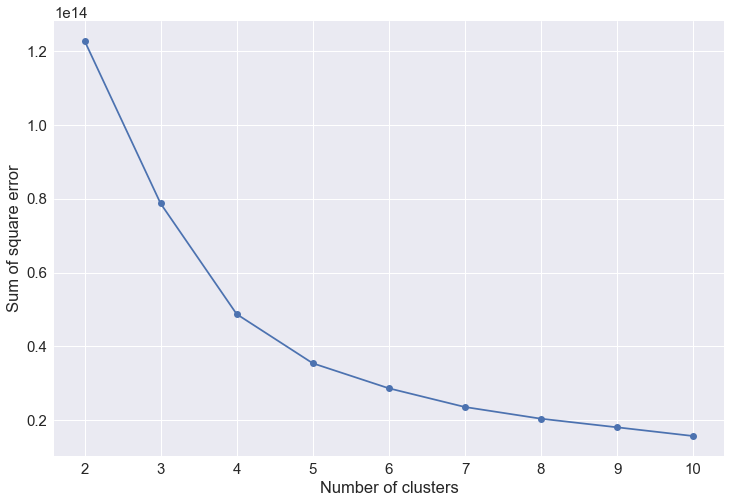

In [562]:
# making the numpy matrix
x_cols = tsne_features

# list of number of clusters to iterate over
numbers = list(range(2,11))

# empty list of sum of square error
SS = []

for k in numbers: 
    # instantiating KMeans
    k_model = KMeans(n_clusters = k)
    
    # fitting model
    k_model.fit(x_cols)
    
    ## calculating error
    SS.append(k_model.inertia_)
    
# making a scatter plot
plt.figure(figsize=(12,8))
plt.plot(numbers, SS, marker = 'o')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of square error')

In the plot above, the elbow is not obvious. For this reason, the silhouette score method will be used to evaluate the optimal number of clusters. 

#### KMeans clustering using the silhouette method

For n_clusters = 2 The average silhouette_score is : 0.651019253375
For n_clusters = 3 The average silhouette_score is : 0.637068852775
For n_clusters = 4 The average silhouette_score is : 0.578368141986
For n_clusters = 5 The average silhouette_score is : 0.480907196863
For n_clusters = 6 The average silhouette_score is : 0.430048768872
For n_clusters = 7 The average silhouette_score is : 0.415849088446
For n_clusters = 8 The average silhouette_score is : 0.376880552658
For n_clusters = 9 The average silhouette_score is : 0.377041754797
For n_clusters = 10 The average silhouette_score is : 0.382957649183


Text(0,0.5,'Average Silhouette Score')

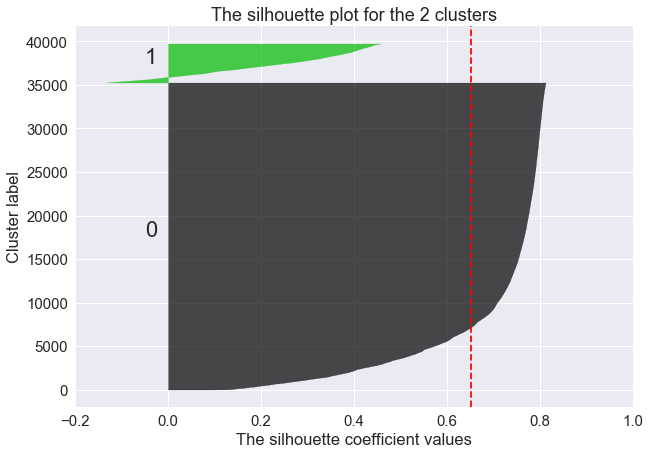

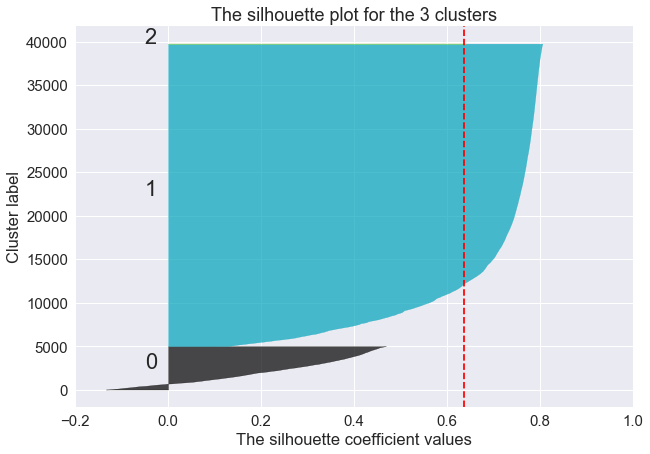

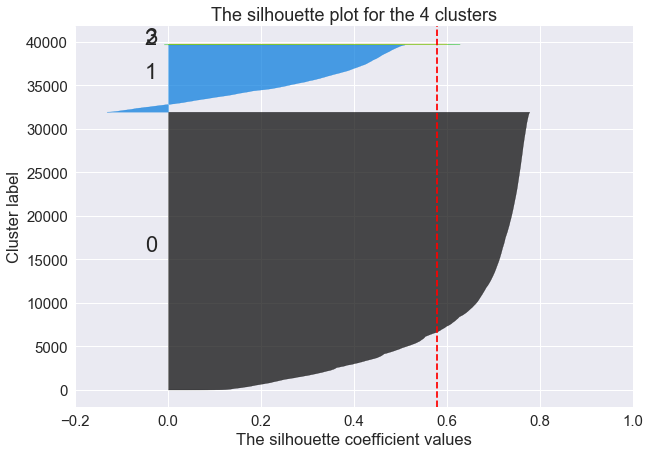

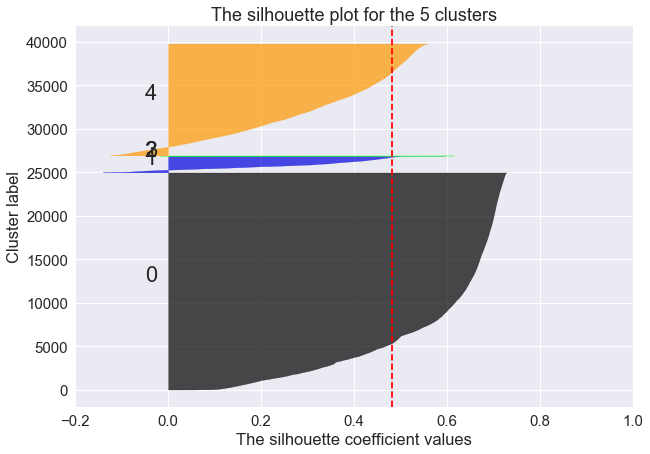

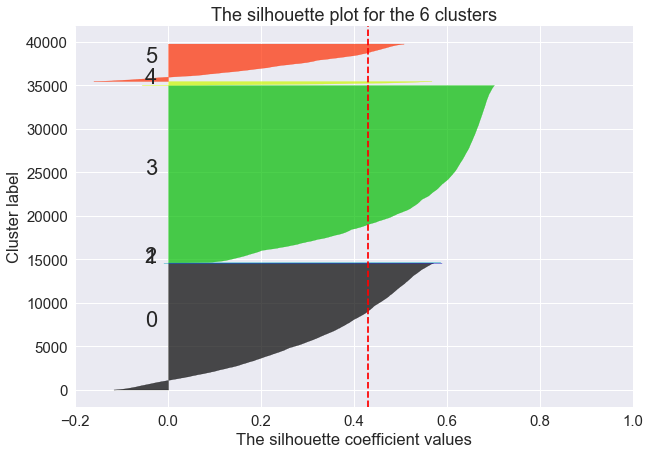

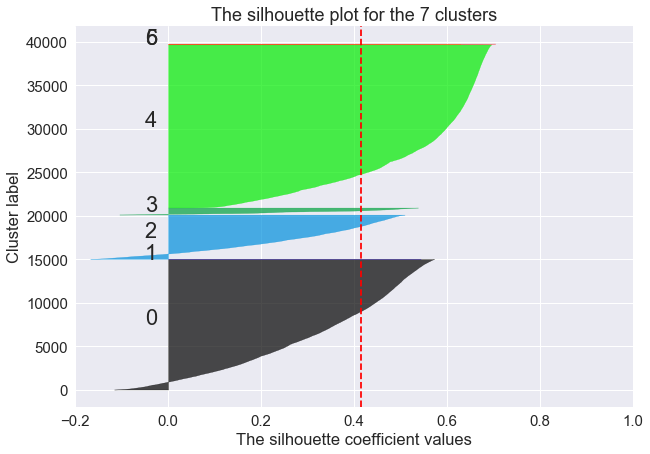

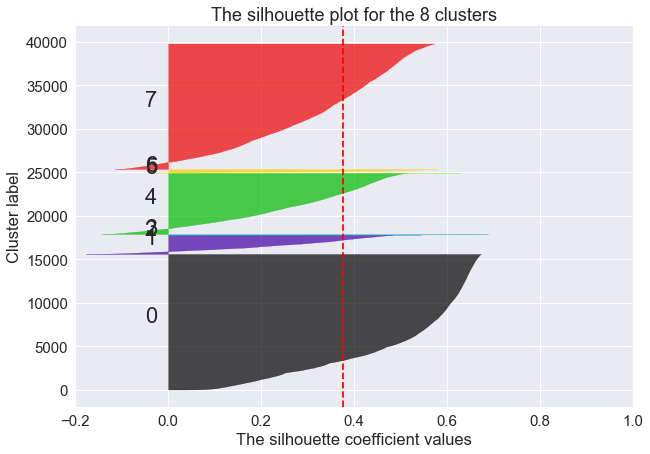

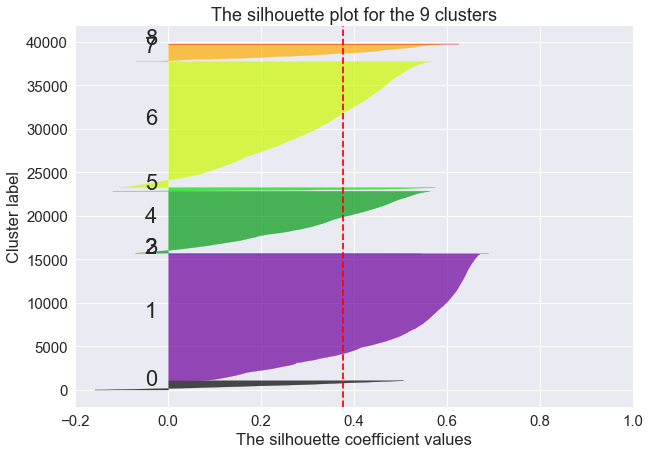

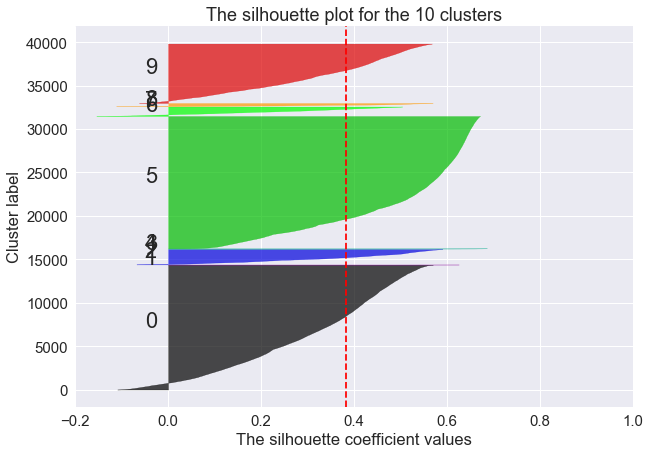

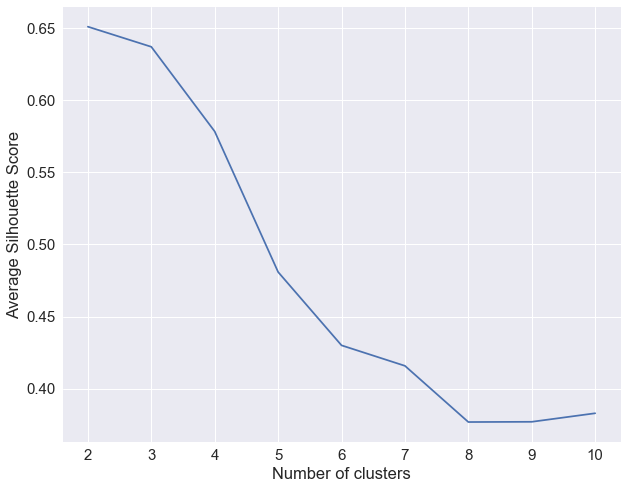

In [563]:
# creating empty list for silhouette average scores
silhouette_avgs = list()

# creating array
best_labels = 0

for index, n_clusters in enumerate(numbers):
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(10, 7)
    
    # setting x-axis limits
    ax1.set_xlim([-0.2, 1])
    
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(x_cols)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(x_cols, cluster_labels)
    
    # storing best_labels
    if  index == 0:
        best_labels = cluster_labels
    elif silhouette_avg > max(silhouette_avgs):
        np.delete(best_labels)
        best_labels = cluster_labels

    silhouette_avgs.append(silhouette_avg)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_cols, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the " + str(i+1) + " clusters")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    
# make line graph of silhoute average scores
plt.figure(figsize=(10,8))
plt.plot(numbers, silhouette_avgs)
plt.xlabel("Number of clusters")
plt.ylabel("Average Silhouette Score")

Text(0.5,1,'t-SNE plot for K = 2')

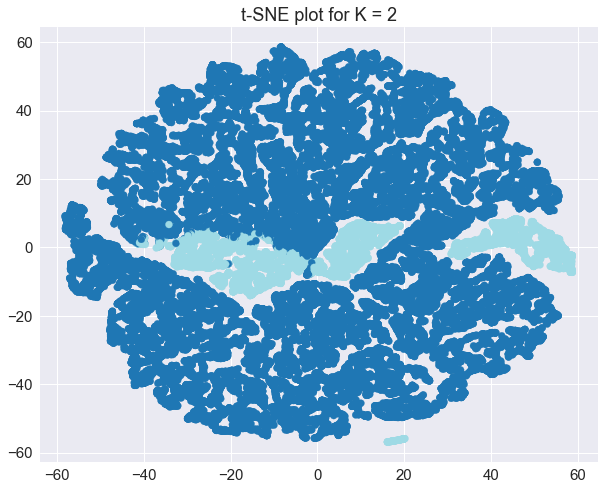

In [564]:
# calculating number of clusters
num_clusters = len(np.unique(best_labels))
    
# creating a 2D plot
colormap = plt.get_cmap('tab20')
plt.figure(figsize = (10,8))
plt.scatter(xs,ys, c = best_labels, cmap = colormap)
plt.title('t-SNE plot for ' +'K = ' + str(num_clusters))

In [350]:
# adding clustering labels to loan data dataframe
kmeans_df = loan_data.copy()
kmeans_df['labels'] = best_labels

# print number of people in each cluster
kmeans_df['labels'].value_counts()

0    35266
1     4470
Name: labels, dtype: int64

The silhouette method indicates that the optimal number of clusters is 2. The above table output shows the size of each of the clusters. We note that one of the clusters is about 8 times larger than the other. Next we have a quick search for differences between the two clusters by comparing the proportions and means of their features.  

In [360]:
# create groups
grouped = kmeans_df.groupby(['labels']).mean()
columns_review = ['loan_amnt', 'annual_inc' , 'age_cr_line', 'fico_average', 'loan_status']
grouped[columns_review]

,loan_amnt,annual_inc,age_cr_line,fico_average,loan_status
labels,,,,,
0,11272.558555,69143.823741,165.528526,717.039840,0.857597
1,10979.407159,67950.855002,166.324385,716.837808,0.858613


Overall, there does not appear to be a significant difference between the proportions and means of both clusters that is worth further investigating. We do note that the borrowers in the smaller cluster request smaller loan amounts on average and have lower average annual incomes. Nevertheless, the clusters don't appear to distinguish between any of the features of concern. 

Clustering this dataset doesn't appear to be yielding insights. Consequently, we test other ensemble methods to try and make further improvements in the hold out set AUROC. 

### Ensemble Methods
The other ensemble methods implemented are boosting and blending.

For boosting, an XGBoost classifier will be used. The blending ensemble base learners include the following models:
* Logistic regression classifier: The best logisitic regression classifier developed during the grid search
* XGBoost classifier: As no XGBoost classifier was developed, some parameters(learning rate, number of estimators, max depth and subbsample proportion) used are based on suggestions from the papers [Data-driven advice for applying machine learning to bioinformatics problems](https://arxiv.org/pdf/1708.05070.pdf) and [Complete guide to parameter tuning in XGboost](https://xgboost.readthedocs.io/en/latest/parameter.html). The class weight (scale_pos_weight) used is based on the xgboost documentation. 

AUROC Scores of Hold-out Set:
xgb: 0.706493545743
lr: 0.6961411294
avg_ensemble: 0.70419794315
Confusion matrix, without normalization
[[ 917  478]
 [3041 5498]]
Confusion matrix, without normalization
[[ 966  429]
 [3307 5232]]


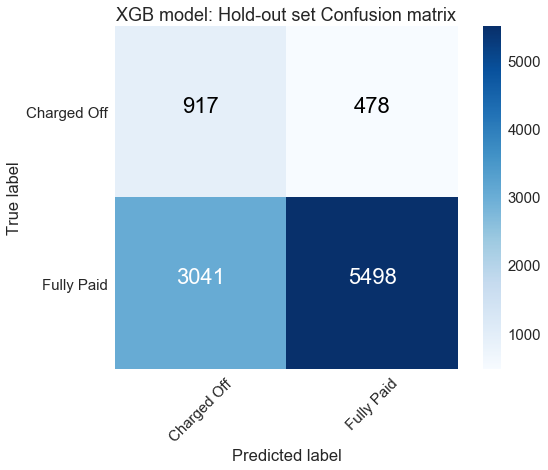

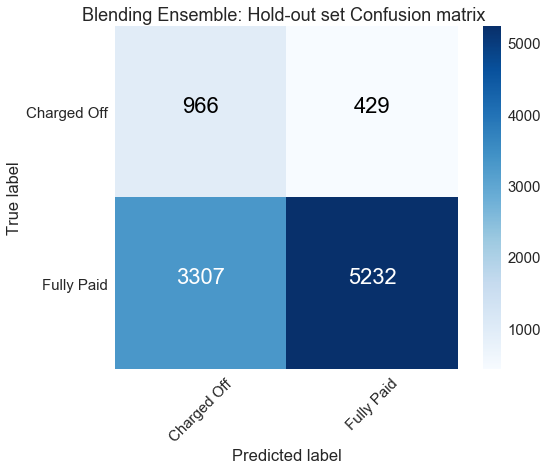

In [599]:
# Instantiating base learners
xgb_clf = xgb.XGBClassifier(objective = "binary:logistic",
                            learning_rate = 0.03,
                            n_estimators = 200,
                            max_depth = 4,
                            subsample = 0.35,
                            scale_pos_weight = ratio,
                            min_child_weight=10, 
                            gamma = 0.1)


lr_clf =  LogisticRegression(solver = 'liblinear', C = 30, class_weight = {0:7, 1:1})

         
# Fitting the voting classifier
voting_clf = VotingClassifier([("xgb", xgb_clf),("lr", lr_clf)],
                              voting="soft", flatten_transform=True)

voting_clf.fit(X_train, y_train)

# storing model objects
xgb_model, lr_model = voting_clf.estimators_

models = {"xgb": xgb_model,
          "lr": lr_model,
          "avg_ensemble": voting_clf}

# Printing title
print("AUROC Scores of Hold-out Set:")

# printing the roc_auc_score of each model 
for name, model in models.items():
    model_probs = model.predict_proba(X_test)[:, 1:]
    model_auc_score = roc_auc_score(y_test, model_probs)
    print(str(name) + ': ' +  str(model_auc_score))
    

xgb_matrix= confusion_matrix(y_test, xgb_model.predict(X_test.astype(float)))
class_names = ['Charged Off', "Fully Paid"]
np.set_printoptions(precision=2)

voting_matrix= confusion_matrix(y_test, voting_clf.predict(X_test.astype(float)))
class_names = ['Charged Off', "Fully Paid"]
np.set_printoptions(precision=2)

# Plot hold out set confusion matrix
plt.figure(figsize = (9,7))
plot_confusion_matrix(xgb_matrix, classes=class_names, title='XGB model: Hold-out set Confusion matrix')

plt.figure(figsize = (9,7))
plot_confusion_matrix(voting_matrix, classes=class_names, title='Blending Ensemble: Hold-out set Confusion matrix ')
    

We see above that the XGBoost classifier performs the best with a hold-out set AUROC value of 0.706. The average ensemble method (hold-out set AUROC of 0.705) performs better than the logistic regression model (hold-out set AUROC of 0.697). 

A comparison of the confusion matrices obtained using voting classifier and the XGB Classifier reveals that the while the XGB classifier performs better at identifying fully paid loans, the average ensemble performs better at identifying charged off loans. 

The ROC curves for the models mentioned above is shown below.

Text(0.5,1,'ROC curve')

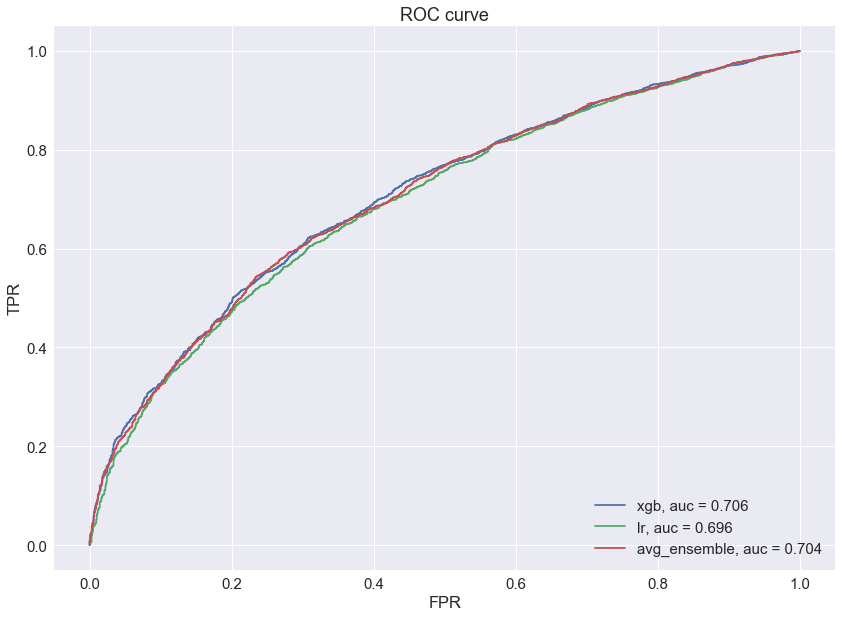

In [600]:
# Plotting ROC curves 
fig, axes = plt.subplots(1, 1, figsize=(14, 10))
for name, model in models.items():
  model_probs = model.predict_proba(X_test)[:, 1:]
  model_auc_score = roc_auc_score(y_test, model_probs)
  fpr, tpr, _ = roc_curve(y_test, model_probs)
  axes.plot(fpr, tpr, label=f"{name}, auc = {model_auc_score:.3f}")
    
axes.legend(loc="lower right")
axes.set_xlabel("FPR")
axes.set_ylabel("TPR")
axes.set_title("ROC curve")

The primary goal of this notebook is to create a model for the conservative investor. To illustrate how to use these models, it will be assumed the conservative investor is only willing to accept a default risk of ~5%. To this end, the penalty parameters of the three best models are tweaked till the predictions of fully paid loans in the hold-out set has a default risk of about 5%.  

AUROC Scores of Hold-out Set:
xgb: 0.705587309503
lr: 0.668917524107
avg_ensemble: 0.693498730891
Confusion matrix, without normalization
[[1260  135]
 [5797 2742]]
Confusion matrix, without normalization
[[1303   92]
 [6643 1896]]
Confusion matrix, without normalization
[[1294  101]
 [6175 2364]]


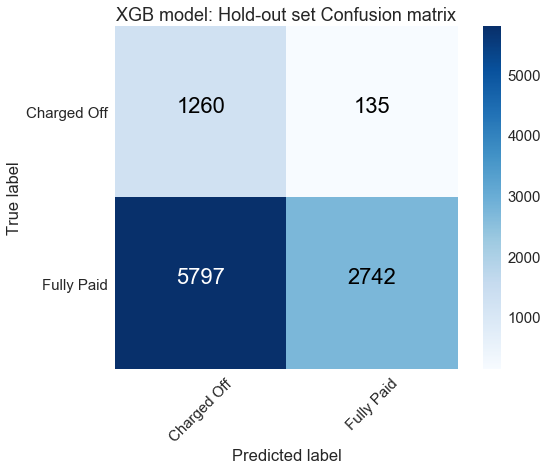

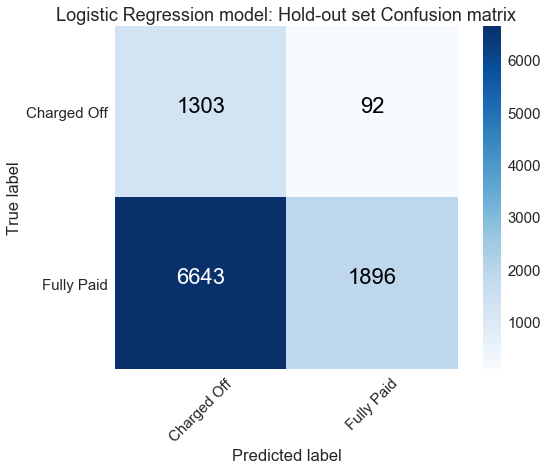

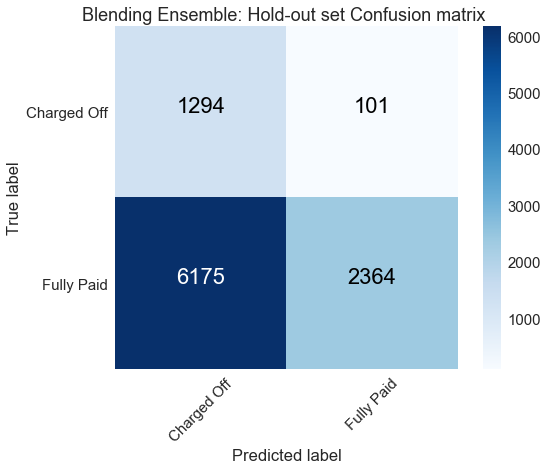

In [596]:
xgb_clf = xgb.XGBClassifier(objective = "binary:logistic",
                            learning_rate = 0.03,
                            n_estimators = 200,
                            max_depth = 4,
                            subsample = 0.35,
                            scale_pos_weight = ratio-0.079,
                            min_child_weight=10, 
                            gamma = 0.1)


lr_clf =  LogisticRegression(solver = 'liblinear', C = 30, class_weight = {0:12, 1:1})

         
# Fitting the voting classifier
voting_clf = VotingClassifier([("xgb", xgb_clf),("lr", lr_clf)],
                              voting="soft", flatten_transform=True)

voting_clf.fit(X_train, y_train)

# storing model objects
xgb_model, lr_model = voting_clf.estimators_

models = {"xgb": xgb_model,
          "lr": lr_model,
          "avg_ensemble": voting_clf}

# Printing title
print("AUROC Scores of Hold-out Set:")

# printing the roc_auc_score of each model 
for name, model in models.items():
    model_probs = model.predict_proba(X_test)[:, 1:]
    model_auc_score = roc_auc_score(y_test, model_probs)
    print(str(name) + ': ' +  str(model_auc_score))
    

lr_matrix = confusion_matrix(y_test, lr_model.predict(X_test.astype(float)))
class_names = ['Charged Off', "Fully Paid"]
np.set_printoptions(precision=2)    

xgb_matrix= confusion_matrix(y_test, xgb_model.predict(X_test.astype(float)))
class_names = ['Charged Off', "Fully Paid"]
np.set_printoptions(precision=2)

voting_matrix= confusion_matrix(y_test, voting_clf.predict(X_test.astype(float)))
class_names = ['Charged Off', "Fully Paid"]
np.set_printoptions(precision=2)

# Plot hold out set confusion matrix
plt.figure(figsize = (9,7))
plot_confusion_matrix(xgb_matrix, classes=class_names, title='XGB model: Hold-out set Confusion matrix')

plt.figure(figsize = (9,7))
plot_confusion_matrix(lr_matrix, classes=class_names, title='Logistic Regression model: Hold-out set Confusion matrix')

plt.figure(figsize = (9,7))
plot_confusion_matrix(voting_matrix, classes=class_names, title='Blending Ensemble: Hold-out set Confusion matrix ')
    

A review of the three best models with fully paid predictions having default rates of approximately 5% reveals that the logistic regression model has the fewest number of false and true positives while the XGB model has the largest number of false and true positives. 

Tweaking the penalty parameters of each model can further reduce the number of false positives; however, this will be at the expense of the number of true positives. For instance, let's consider the test data which is composed of 9,930 borrowers. We know that 8539 of these borrowers fully paid their loans. However, the XGB boost model with a default risks of ~5% only correctly identifies 2742 of these borrowers. The previous XGBoost model which had a default risk of ~8% was able to identify 5232 of these borrowers. 

In short, while it is possible to develop models with very low default risks, investors will have to be willing to patiently search for borrowers that meet their criteria. According to the [blog post](https://www.moneyunder30.com/lending-club-investing) of David Weliver, a long term Lending Club investor and founder of Money Under 30, this may be difficult because institutional investors are using algorithms and analysts to find the best loans. Consequently, the less risky loans are funded very quickly.  

Finally, it is worth noting that tweaking the model parameters so that the default risk in the hold-out set is 0 does not guarantee that a borrower invested in will not default. Models developed do not account for all forms of risks (e.g. people losing all their property to a wildfire).   

Further work can be done to try and improve the models developed or advance this work. A few considerations include:
* Testing other algorithms (e.g neural network) and other ensemble methods (e.g stack ensemble). 
* Including the more recent Lending Club data available on the Lending Club Website.
* Fully categorizing the employer data. 


